In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [113]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [114]:
df=pd.read_csv("/content/drive/MyDrive/country_data.csv")

In [115]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [229]:
len(df)

167

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [117]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [119]:
countries=df.country
df.drop("country", axis=1, inplace=True)

#### Standardising the feautures

In [120]:
def zscore_normalise_features(x):
    mu=np.mean(x,axis=0)
    sd=np.std(x,axis=0)
    x_norm=(x-mu)/sd
    return mu,sd,x_norm
mu,sd,df=zscore_normalise_features(df)

#### Initialising centroids using K++

In [216]:
def init_centroids(X, k, random_state=123):

    np.random.seed(random_state)
    n_samples, n_features = X.shape

    # Step 1: Choose the first centroid randomly from the data points
    centroids = []
    first_centroid_idx = np.random.randint(n_samples)
    centroids.append(X[first_centroid_idx])

    # Step 2: Select remaining k-1 centroids
    for _ in range(1, k):
        # Compute the squared distances between each point and the nearest centroid
        distances = np.min([np.linalg.norm(X - c, axis=1)**2 for c in centroids], axis=0)

        # Compute probabilities proportional to the squared distances
        probabilities = distances / np.sum(distances)

        # Choose the next centroid using the computed probabilities
        next_centroid_idx = np.random.choice(n_samples, p=probabilities)
        centroids.append(X[next_centroid_idx])

    return np.array(centroids)


In [217]:
def find_closest_centroids(X, centroids):
    K = centroids.shape[0]
    idx = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        l=X[i]-centroids[0]
        l**=2
        d=np.sum(l)
        min_d=d
        index=0

        for j in range(1,K):
            l=X[i]-centroids[j]
            l**=2
            d=np.sum(l)
            if (d<min_d):
                min_d=d
                index=j
        idx[i]=index
    return idx

In [218]:
def compute_centroids(X, idx, K):
    m, n = X.shape
    centroids = np.zeros((K, n))
    for i in range(K):
        total=np.zeros((1,n))
        count=0
        for j in range (m):
            if idx[j]==i:
                total+=X[j]
                count+=1
        total/=count
        centroids[i]=total
    return centroids

In [219]:
def wcss(x, idx, centroids):
    #x is a numpy array
    wcss=0
    m=x.shape[0]
    for i in range(len(x)):
        id=idx[i]
        wcss+=np.sum((x[i]-centroids[id])**2)
    return wcss

In [220]:
def silhouette_score(x, k, idx, centroids):

    m = x.shape[0]
    total_score = 0

    # Loop over each data point
    for i in range(m):
        id = idx[i]

        # Intra-cluster distance (a)
        a = 0
        same_cluster_points = x[idx == id]  # Points in the same cluster
        for point in same_cluster_points:
            a += np.sum((x[i] - point) ** 2)
        a /= len(same_cluster_points)  # Average intra-cluster distance

        # Inter-cluster distance (b)
        b = np.inf  # Start with a very high value for the minimum
        for j in range(k):
            if j != id:
                other_cluster_points = x[idx == j]  # Points in a different cluster
                inter_dist = 0
                for point in other_cluster_points:
                    inter_dist += np.sum((x[i] - point) ** 2)
                inter_dist /= len(other_cluster_points)  # Average inter-cluster distance
                b = min(b, inter_dist)  # Find the nearest cluster

        # Compute silhouette coefficient for this point
        epsilon = 1e-8
        silhouette_coeff = (b - a) / (max(a, b) + epsilon)


        total_score += silhouette_coeff

    # Average silhouette score for all points
    silhouette_score = total_score / m

    return silhouette_score


In [221]:
max_iters=3
def run_kMeans(X, K, max_iters=15, plot_progress=True):
    centroids = init_centroids(X,K)
    #print(centroids)
    m, n = X.shape

    WCSS=[]
    for i in range(max_iters):
        #print("K-Means iteration %d/%d" % (i, max_iters-1))
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, K)
        WCSS.append(wcss(X,idx,centroids))

    return centroids, idx, WCSS



###Finding optimal number of clusters
* elbow method (wcss vs k)
* silhouette score vs k

In [222]:
sil_score=[]
wcss_arr=[]
for i in range(2,11):
    centroids,idx,WCSS=run_kMeans(X=df.to_numpy(),K=i)
    sil_score.append(silhouette_score(df.to_numpy(),i,idx,centroids))
    wcss_arr.append(wcss(df.to_numpy(),idx,centroids))

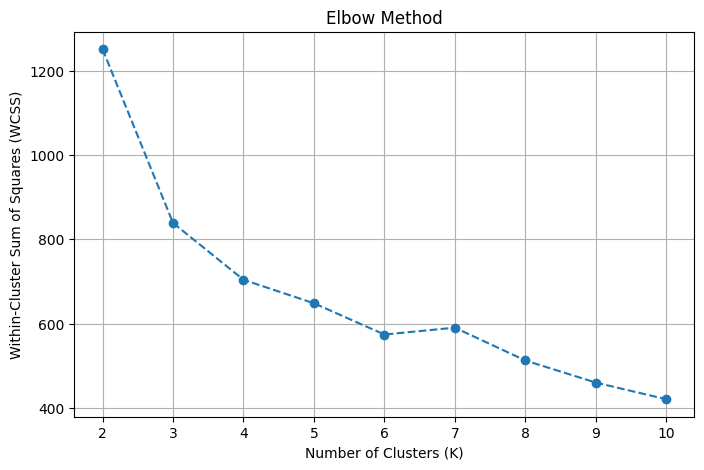

In [223]:
K_range = range(2, 11)
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss_arr, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(K_range)
plt.grid(True)
plt.show()

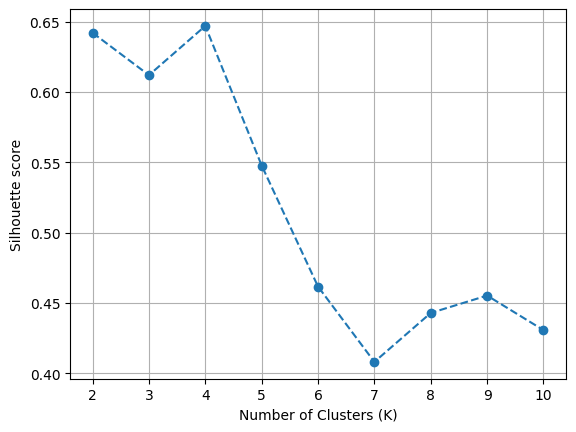

In [224]:
plt.plot(K_range, sil_score, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette score')
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [230]:
centroids,idx,WCSS=run_kMeans(df.to_numpy(),3, max_iters=15)

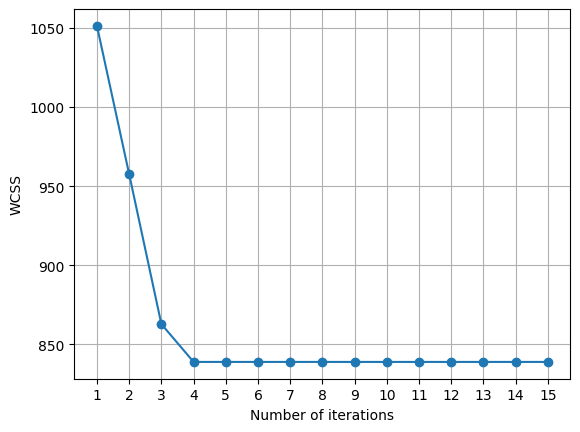

In [231]:
iter_range=range(1,16)
plt.plot(iter_range, WCSS, marker='o')
plt.xlabel('Number of iterations')
plt.ylabel('WCSS')
plt.xticks(iter_range)
plt.grid(True)
plt.show()

In [232]:
centroids

array([[ 1.31279934, -0.44417427, -0.17280342, -0.19206238, -0.68942628,
         0.38237968, -1.25887373,  1.31942807, -0.6059922 ,  1.93877551],
       [-0.82985801,  0.6150709 ,  0.80342073,  0.14942456,  1.57803837,
        -0.48186651,  1.11979699, -0.77777456,  1.77123477,  3.90625   ],
       [-0.43920594,  0.02421244, -0.20048948,  0.05383105, -0.19436442,
        -0.03856833,  0.30059662, -0.46236267, -0.31378947,  0.        ]])

### Evaluation of Kmeans using silhouette score

In [233]:
ss=silhouette_score(df.to_numpy(),2,idx,centroids)
print(f'silhouette score for kmeans {ss}')

silhouette score for kmeans 0.7177928077652663


In [234]:
df['kmeans']=idx

In [235]:
y=df['kmeans']
x=df.drop("kmeans", axis=1)

###Visualising clusters using PCA

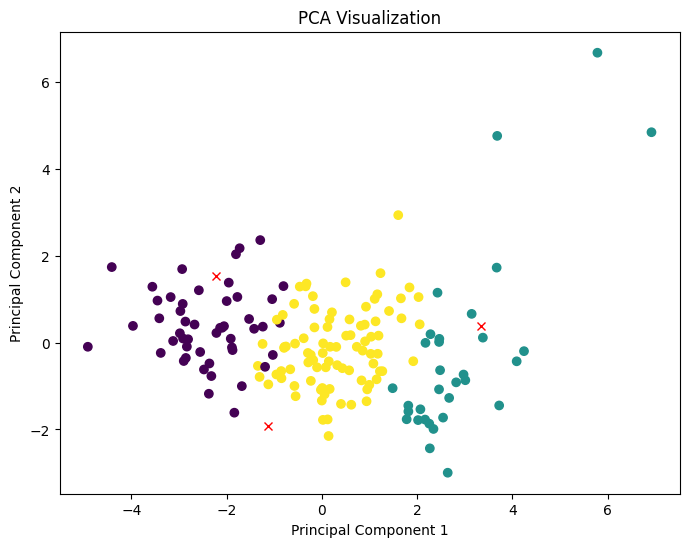

In [236]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
centroids_projected=pca.fit_transform(centroids)

plt.figure(figsize=(8, 6))
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'],c=df['kmeans'])

plt.plot(centroids_projected[:,0],centroids_projected[:,1],'x',color='red')
plt.xlabel('Principal Component 1')

plt.ylabel('Principal Component 2')
plt.title('PCA Visualization')
plt.show()


In [237]:
from sklearn.metrics import f1_score

In [238]:
from sklearn.model_selection import train_test_split
x_train, x_test,y_train,y_test=train_test_split(x,y, train_size=0.8, random_state=123)

In [249]:
def most_common(lst):
    return max(set(lst), key=lst.count)
def euclidean(point, data):
    # Euclidean distance between points a & data
    return np.sqrt(np.sum((point - data)**2, axis=1))
class KNeighborsClassifier:
    def __init__(self, k=5, dist_metric=euclidean):
        self.k = k
        self.dist_metric = dist_metric
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    def predict(self, X_test):
      neighbors = []
      for i, x in enumerate(X_test):
        distances = self.dist_metric(x, self.X_train)
        # Sort distances and get corresponding labels
        sorted_labels = [label for _, label in sorted(zip(distances, self.y_train))]
        # Pick top k neighbors
        top_k_neighbors = sorted_labels[:self.k]
        neighbors.append(top_k_neighbors)
      return [most_common(neighbors_list) for neighbors_list in neighbors]


    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = np.sum(np.array(y_pred) == np.array(y_test)) / len(y_test) # Convert to NumPy arrays for element-wise comparison
        return accuracy



###Finding optimal value of k for knn

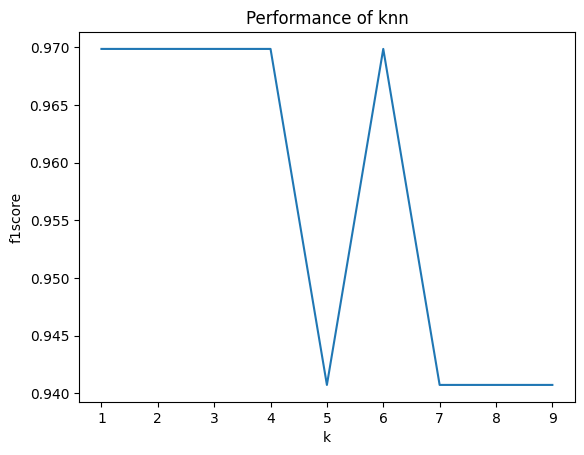

In [248]:
f1_scores= []
accuracies=[]
ks = range(1, 10)
for k in ks:
    knn = KNeighborsClassifier(k=k)
    knn.fit(x_train.to_numpy(), y_train.to_numpy())
    y_preds=knn.predict(x_test.to_numpy())
    f1=f1_score(y_test, y_preds,average="weighted")
    accuracy = knn.evaluate(x_test.to_numpy(), y_test.to_numpy())
    accuracies.append(accuracy)
    f1_scores.append(f1)
# Visualize accuracy vs. k
fig, ax = plt.subplots()
ax.plot(ks, f1_scores)
ax.set(xlabel="k",
       ylabel="f1score",
       title="Performance of knn")
plt.show()

###Running knn with k=3

In [240]:
knn = KNeighborsClassifier(k=3)
knn.fit(x_train.to_numpy(), y_train.to_numpy())
y_preds=knn.predict(x_test.to_numpy())
f1=f1_score(y_test, y_preds,average="weighted")
accuracy = knn.evaluate(x_test.to_numpy(), y_test.to_numpy())

###Evaluating model using cm and f1 score

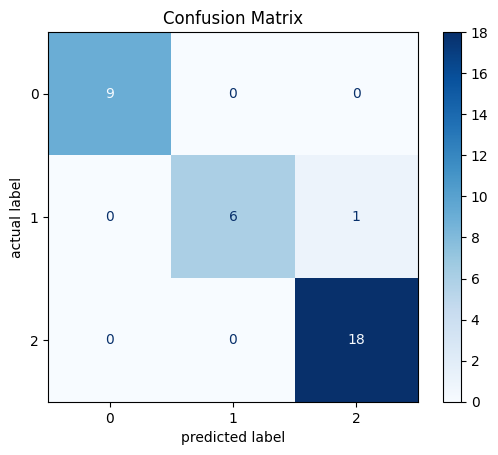

In [246]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('predicted label')
plt.ylabel('actual label')
plt.show()

In [247]:
print(f"f1 score: {f1}")

f1 score: 0.9698544698544699


In [241]:
df_new=pd.concat([df,countries],axis=1)

In [242]:
df_new

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans,country
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180,0,Afghanistan
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623,2,Albania
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376,2,Algeria
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268,0,Angola
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817,2,Antigua and Barbuda
...,...,...,...,...,...,...,...,...,...,...,...
162,-0.225578,0.200917,-0.571711,0.240700,-0.738527,-0.489784,-0.852161,0.365754,-0.546913,2,Vanuatu
163,-0.526514,-0.461363,-0.695862,-1.213499,-0.033542,3.616865,0.546361,-0.316678,0.029323,2,Venezuela
164,-0.372315,1.130305,0.008877,1.380030,-0.658404,0.409732,0.286958,-0.661206,-0.637754,2,Vietnam
165,0.448417,-0.406478,-0.597272,-0.517472,-0.658924,1.500916,-0.344633,1.140944,-0.637754,0,Yemen


In [144]:
df_new.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans,country
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180,1,Afghanistan
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623,0,Albania
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376,0,Algeria
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268,1,Angola
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817,0,Antigua and Barbuda


In [145]:
# Assuming 'df_new' is your DataFrame and 'kmeans' is the column with cluster assignments
df_new = df_new.set_index(['kmeans', df_new.index])

In [146]:
df_new

child_mort   exports    health   imports    income  inflation  \
kmeans                                                                      
1      0      1.291532 -1.138280  0.279088 -0.082455 -0.808245   0.157336   
0      1     -0.538949 -0.479658 -0.097016  0.070837 -0.375369  -0.312347   
       2     -0.272833 -0.099122 -0.966073 -0.641762 -0.220844   0.789274   
1      3      2.007808  0.775381 -1.448071 -0.165315 -0.585043   1.387054   
0      4     -0.695634  0.160668 -0.286894  0.497568  0.101732  -0.601749   
...                ...       ...       ...       ...       ...        ...   
1      162   -0.225578  0.200917 -0.571711  0.240700 -0.738527  -0.489784   
0      163   -0.526514 -0.461363 -0.695862 -1.213499 -0.033542   3.616865   
       164   -0.372315  1.130305  0.008877  1.380030 -0.658404   0.409732   
1      165    0.448417 -0.406478 -0.597272 -0.517472 -0.658924   1.500916   
       166    1.114951 -0.150348 -0.338015 -0.662477 -0.721358   0.590015   

            life_expec  total_fer      gdpp              country  
kmeans                                                            
1      0     -1.619092   1.902882 -0.679180          Afghanistan  
0      1      0.647866  -0.859973 -0.485623              Albania  
       2      0.670423  -0.038404 -0.465376              Algeria  
1      3     -1.179234   2.128151 -0.516268               Angola  
0      4      0.704258  -0.541946 -0.041817  Antigua and Barbuda  
...                ...        ...       ...                  ...  
1      162   -0.852161   0.365754 -0.546913              Vanuatu  
0      163    0.546361  -0.316678  0.029323            Venezuela  
       164    0.286958  -0.661206 -0.637754              Vietnam  
1      165   -0.344633   1.140944 -0.637754                Yemen  
       166   -2.092785   1.624609 -0.629546               Zambia  

[167 rows x 10 columns]

###Agglomerative clustering

In [302]:
import numpy as np
from scipy.spatial.distance import euclidean

class AgglomerativeClustering:
    def __init__(self, n_clusters=2):
       self.n_clusters = n_clusters
       self.clusters = None

    def fit(self, data):

        self.data = data
        n_samples = data.shape[0]
        self.clusters = [[i] for i in range(n_samples)]

        while len(self.clusters) > self.n_clusters:
            dist_matrix = self._compute_distance_matrix()
            i, j = np.unravel_index(np.argmin(dist_matrix), dist_matrix.shape)
            self._merge_clusters(i, j)
    def _compute_distance_matrix(self):

       n_clusters = len(self.clusters)
       dist_matrix = np.full((n_clusters, n_clusters), np.inf)
       for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            dist = max(
                euclidean(self.data[p1], self.data[p2])
                for p1 in self.clusters[i]
                for p2 in self.clusters[j]
            )
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist
        return dist_matrix


    def _merge_clusters(self, i, j):

        self.clusters[i].extend(self.clusters[j])
        self.clusters.pop(j)

    def get_clusters(self):

        return self.clusters
    def plot_clusters_with_pca(self):

        if not self.clusters:
            raise ValueError("Model has not been fitted yet.")

        # Apply PCA to reduce data to 2D
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(self.data)

        # Generate distinct colors for the clusters
        colors = cm.rainbow(np.linspace(0, 1, len(self.clusters)))

        # Plot each cluster
        for cluster, color in zip(self.clusters, colors):
            points = reduced_data[cluster]
            plt.scatter(points[:, 0], points[:, 1], color=color, label=f'Cluster {self.clusters.index(cluster)}')

        # Add plot details
        plt.title("Cluster Visualization with PCA")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.legend()
        plt.show()

model = AgglomerativeClustering(n_clusters=3)
model.fit(df.to_numpy())
clusters = model.get_clusters()

    # Print results
print(f"Final clusters: {clusters}")


Final clusters: [[0, 94, 25, 147, 155, 166, 106, 64, 28, 56, 129, 63, 150, 40, 97, 17, 112, 36, 93, 32, 37, 59, 99, 142, 80, 84, 108, 50, 3, 165, 116, 55, 72, 21, 149, 26, 136, 137, 126, 146, 162, 19, 69, 38, 62, 127, 109, 27, 47, 151, 120, 81, 83, 107, 105, 12, 65, 18, 161, 52, 45, 118, 143, 30, 78, 16, 2, 70, 49, 141, 79, 61, 46, 48, 76, 9, 119, 6, 154, 152, 88, 34, 1, 124, 153, 100, 71, 4, 156, 57, 164, 24, 125, 92, 117, 35, 160, 96, 14, 13, 103, 5, 140, 10, 22, 85, 33, 104, 90, 41, 86, 148, 121, 89, 101, 74, 128, 130, 51, 95, 102, 39, 42, 11, 20, 135, 43, 67, 138, 115, 134, 111, 122, 60, 158, 163, 68, 139, 53, 75, 131, 157, 54, 7, 144, 58, 29, 15, 77, 87, 8, 44, 110, 73, 82, 23, 132, 31, 159, 114, 145, 98, 66, 123, 133], [91], [113]]


In [303]:
cluster_labels = -1 * np.ones(len(df), dtype=int)

# Assign cluster labels based on the clusters
for cluster_label, cluster_indices in enumerate(clusters):
    cluster_labels[cluster_indices] = cluster_label

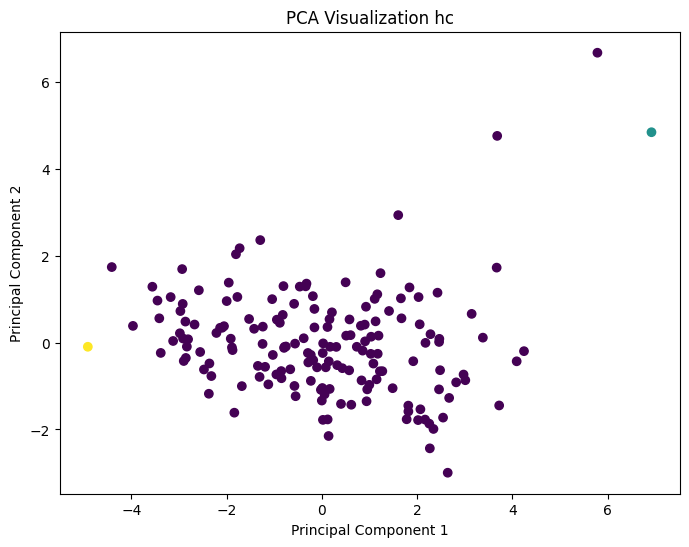

In [304]:
df_hc=df
df_hc['hc']=cluster_labels
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
centroids_projected=pca.fit_transform(centroids)

plt.figure(figsize=(8, 6))
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'],c=df_hc['hc'])


plt.xlabel('Principal Component 1')

plt.ylabel('Principal Component 2')
plt.title('PCA Visualization hc')
plt.show()
